# **Object Detection**

## What is it?
Object Detection is a task in computer vision which involves identifying the presence, location and type of one or more objects in an image! 

In order to achieve this, we need to:
1. Recognize the objects (where is the object)
2. Know the objects extent (object localization)
3. Recognize what the object is (object classification)


To achieve object detection, we will use a Region-Based Convolutional Neural Network (R-CNN). Instead of building our own Mask R-CNN model from scratch, we will use a reliable third-party implementation built on top of the Keras deep learning framework.


In this notebook, we will use a fruit dataset (with already labeled images) and train an R-CNN model with these image sets. We will further calculate the mean average precision (mAP score) to see how well our model does. 

We will use tensorflow 1.0 since tensorflow 2.0 is not integrated yet.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf 

TensorFlow 1.x selected.


Now, we will get the pre-trained model from matterport and apply transfer learning to be able to find fruit!

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [3]:
import os
os.chdir('Mask_RCNN')
print(os.getcwd())

/content/Mask_RCNN


This repository holds the fruit images we will use to train our model

In [4]:
!git clone https://github.com/aegarro/SR_ObjectDetection.git

Cloning into 'SR_ObjectDetection'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 798 (delta 403), reused 791 (delta 400), pack-reused 0
Receiving objects: 100% (798/798), 35.36 MiB | 23.40 MiB/s, done.
Resolving deltas: 100% (403/403), done.


Run the line below.
If success, you will see:
  Finished processing dependencies for mask-rcnn==2.1

Otherwise, change the line below to read: !sudo python setup.py install

In [5]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/

Import needed libraries

In [6]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.model import MaskRCNN
import tensorflow.compat.v1 as tf

Using TensorFlow backend.


In [0]:
# function to extract bounding boxes from an annotation file
def extract_boxes(path):
  # load and parse the file
  tree = ElementTree.parse(path)
  # get the root of the document
  root = tree.getroot()
  # extract each bounding box
  boxes = list()
  for box in root.findall('.//bndbox'):
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    coors = [xmin, ymin, xmax, ymax]
    boxes.append(coors)
  # extract image dimensions
  width = int(root.find('.//size/width').text)
  height = int(root.find('.//size/height').text)
  return boxes, width, height

# class that defines and loads the fruit dataset
class FruitDataset(Dataset):
	# load the dataset definitions
  def load_dataset(self, dataset_dir):
    # define one class
    self.add_class("dataset", 1, "apple")
    # define data locations
    images_dir = dataset_dir 
    annotations_dir = dataset_dir  # same dir as images
    # find all images
    for filename in listdir(images_dir):
      if '.j' not in filename:
        continue
      # extract image id
      image_id = filename.split(".")[0] # ex: apple_1
      img_path = images_dir + filename
      ann_path = images_dir + image_id + '.xml'
      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box file location
    path = info['annotation']
    # load XML
    boxes, w, h = extract_boxes(path)
    # create one array for all masks, each on a different channel
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('apple'))
    return masks, asarray(class_ids, dtype='int32') 

  # load an image reference
  def image_reference(self, image_id):
	  info = self.image_info[image_id]
	  return info['path']
 

The code below prepares the train and test sets and prints how many images are in each.

In [11]:
# train set
train_set = FruitDataset()
db_path = 'SR_ObjectDetection/apple_images/'
train_set.load_dataset(db_path)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# # test/val set
db_path = 'SR_ObjectDetection/test/'
test_set = FruitDataset()
test_set.load_dataset(db_path)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 92
Test: 19


Let's see an example image:

(177, 284, 3)
(177, 284, 2)


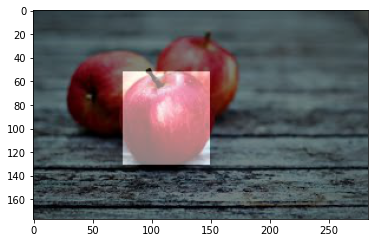

In [12]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

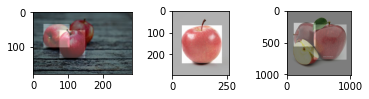

In [13]:
# plot first few images
for i in range(3):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [0]:
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	#print(info)

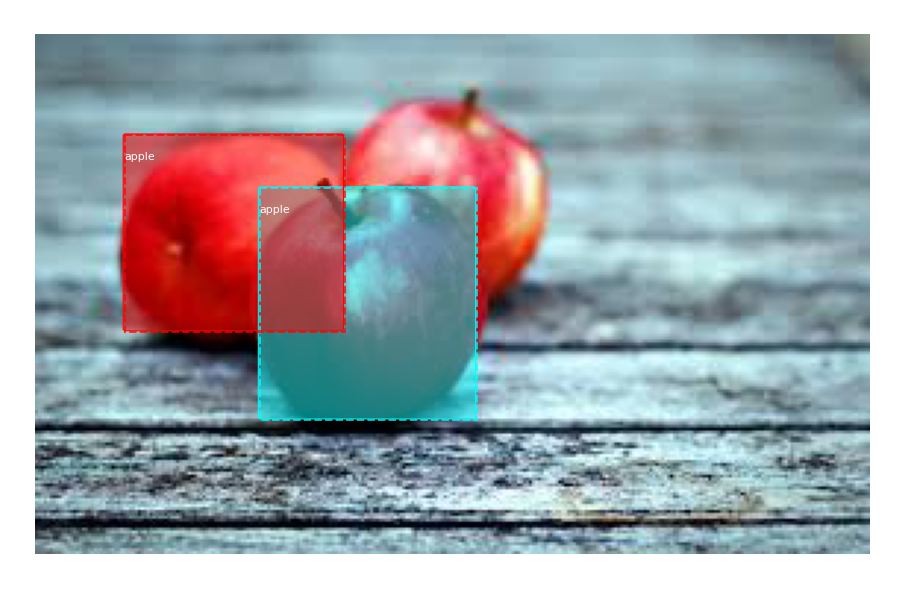

In [15]:
# define image id
image_id = 0
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Prepare the configuration for training

For longer training, see comments for epoch steps and number of epoch

In [16]:
from mrcnn.config import Config
# define a configuration for the model
class FruitConfig(Config):
	# Give the configuration a recognizable name
	NAME = "fruit_cfg"
	# Number of classes (background + fruit)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 20 # for longer training: change to ~50

# prepare config
config = FruitConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Import needed libraries

In [0]:
# fit a mask rcnn on the fruit dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn import visualize

In [18]:
# Directory to save logs and trained model
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [19]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.keras_model.metrics_tensors = []
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
# change epochs to larger number ~20 to acheive better accuracy
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
box_ind is deprecated, use box_indices instead



Starting at epoch 0. LR=0.001

Checkpoint Path: ./fruit_cfg20200502T1757/mask_rcnn_fruit_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



Epoch 1/10
20/20 [==============================] - 163s 8s/step - loss: 2.3247 - val_loss: 0.6759



Epoch 2/10
20/20 [==============================] - 102s 5s/step - loss: 0.9622 - val_loss: 0.8350
Epoch 3/10
20/20 [==============================] - 102s 5s/step - loss: 0.7017 - val_loss: 0.5953
Epoch 4/10
20/20 [==============================] - 102s 5s/step - loss: 0.4988 - val_loss: 0.5327
Epoch 5/10
20/20 [==============================] - 102s 5s/step - loss: 0.5300 - val_loss: 0.3314
Epoch 6/10
20/20 [==============================] - 102s 5s/step - loss: 0.4128 - val_loss: 0.4664
Epoch 7/10
20/20 [==============================] - 102s 5s/step - loss: 0.4735 - val_loss: 0.5251
Epoch 8/10
20/20 [==============================] - 102s 5s/step - loss: 0.3695 - val_loss: 0.2996
Epoch 9/10
20/20 [==============================] - 101s 5s/step - loss: 0.4008 - val_loss: 0.3319
Epoch 10/10
20/20 [==============================] - 102s 5s/step - loss: 0.2832 - val_loss: 0.9413


In [0]:
model.keras_model.save_weights("saved_model.ht");

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
# !ls /content/gdrive/My\ Drive

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "fruit_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [24]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [25]:
# load model weights
# model.load_weights('saved_model.ht', by_name=True)
model_path = model.find_last()
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./fruit_cfg20200502T1757/mask_rcnn_fruit_cfg_0010.h5
Re-starting from epoch 10


In [0]:
# detect fruit in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.model import load_image_gt
from mrcnn.utils import compute_ap
from numpy import mean

In [0]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

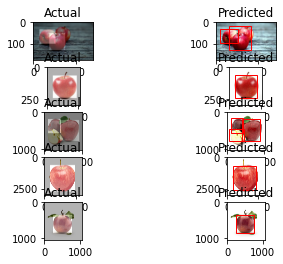

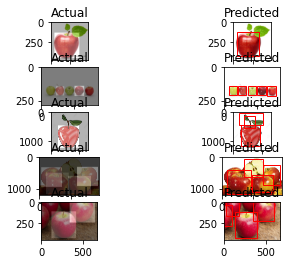

In [28]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

Let's test on a random image!

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  172.00000  max:  971.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


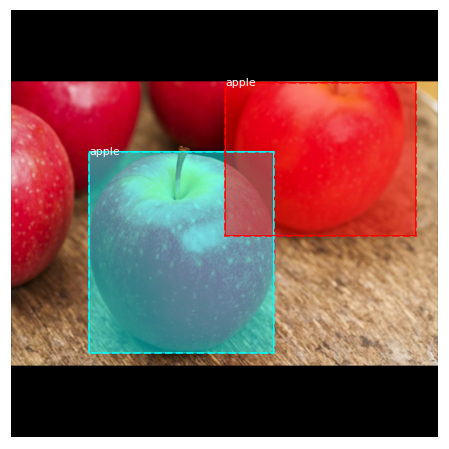

In [29]:
import random
from mrcnn import visualize
from mrcnn.model import log
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(test_set, cfg, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

Now we will calculate the mAP score.

In [0]:
import matplotlib
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [31]:
import numpy as np
import mrcnn.model as modellib

# evaluate model on training dataset

# Compute VOC-Style mAP @ IoU=0.5
image_ids = np.random.choice(test_set.image_ids, test_set.num_images)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, cfg,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, cfg), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    array_sum = np.sum(recalls)
    array_has_nan = np.isnan(array_sum) 
    if (array_has_nan):
      continue
    APs.append(AP)
    
print("Test mAP: %.3f" %np.mean(APs))

Test mAP: 0.886
